# Imports

In [1]:
from pathlib import Path
import sys
import warnings

abs_path = Path().resolve()
sys.path.append(str(abs_path.parent / "modules"))

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from files_funcs import *
from nlp_funcs import *
from ml_funcs import *
from eda_funcs import *


warnings.filterwarnings("ignore")

c:\Users\yytrb\OneDrive\Рабочий стол\atom-compliance-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
main_dir = abs_path.parent.parent

config_path = abs_path.parent.parent / "config" / "config.yaml"
config = load_yaml(config_path)

data_dir = main_dir / "data" / "ds"
model_dir = main_dir / "models"

text_cols = [f'{col}' for col in set(config["ds_topology"]["hmi_subheaders"].values())]
text_cols = text_cols + ["differences"]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


# BERT init

In [3]:
bert_model = (
    BertModel
    .from_pretrained(config["bert"], output_hidden_states=True)
    .to(DEVICE)
)
tokenizer = BertTokenizer.from_pretrained(config["bert"])

display(bert_model)
tokenizer

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

# Loading

In [4]:
ds = pd.read_csv(data_dir / "ds.unl", sep="|")
ds.columns

Index(['id', 'case_name', 'full_uc_text', 'full_ssts_text', 'main_scenario',
       'postconditions', 'preconditions', 'goal', 'other', 'differences',
       'description', 'complience_level', 'target'],
      dtype='object')

# Processing

In [5]:
ssts_texts = pd.DataFrame(ds["full_ssts_text"]).fillna("EMPTY")
ssts_texts_vectorized = extract_text_vectors(
    ssts_texts,
    "full_ssts_text",
    bert_model,
    tokenizer,
    DEVICE,
    verbose=False
).drop("full_ssts_text", axis=1)

for col in text_cols:
    ds[f'f_{col}'] = get_pairwise_dist_with_ssts(
        ds[col],
        ssts_texts_vectorized,
        config["distance_metric"],
        bert_model=bert_model,
        tokenizer=tokenizer,
        device=DEVICE,
        verbose=False
    )

ds

,id,case_name,full_uc_text,full_ssts_text,main_scenario,postconditions,preconditions,goal,other,differences,description,complience_level,target,f_goal,f_preconditions,f_main_scenario,f_postconditions,f_other,f_differences
0,26161,FM Radio Stations switching,[I-26161] FM Radio Stations switching\nDescri...,Automatic search\nFunctional Description\nSupp...,Main Scenario:\nUser presses the forward/backw...,Postconditions:\nout_5/out_2 shows the station...,Preconditions:\nUser has selected FM Radio pla...,NaN,Description: Requirenments:\nThe action is dis...,Next words are missing in UC-text:\n- [I-26161...,Next words are missing in SSTS-text:\n Automat...,NaN,4,0.711589,0.235335,0.189623,0.212765,0.319827,0.236090
1,8800,Receiving Call Notifications,[I-8800] Receiving Call Notifications\nPrecon...,Receiving Call Notifications\nFunctional Descr...,Main Scenario:\nAn incoming call is received o...,"Postconditions:\nIf the call is accepted, the ...",Preconditions\nEntertainment system is ready. ...,NaN,NaN,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,NaN,4,0.715119,0.201947,0.096076,0.089409,0.715119,0.250389
2,25957,Mute/unmute the FM Radio playback,[I-25957] Mute/unmute the FM Radio playback\n...,Mute or pause function\nFunctional Description...,Main Scenario:\n​​​User clicks on Mute/Unmute ...,Postconditions:\nThe user Mutes/Unmutes the FM...,Preconditions:\nUser is playing FM Radio,"Goal: ""Users are able to mute/unmute the FM Ra...",Description:,Next words are missing in UC-text:\n- [I-25957...,Next words are missing in SSTS-text:\n Mute: 1...,NaN,3,0.321766,0.300143,0.210004,0.238178,0.773708,0.233136
3,26771,Turn on and off hotspot via VA,[I-26771] Turn on and off hotspot via VA\n\nD...,\nTurn on and off hotspot\nFunctional Descript...,Main scenario:\nThe user asks in_24 Voice. Mic...,NaN,NaN,Goal: \nUsers can turn on or off the vehicle h...,Description: Scope:\nSWP Android \nVA \nSmartp...,Next words are missing in UC-text:\n- [I-26771...,Next words are missing in SSTS-text:\n Functio...,NaN,4,0.242494,0.738591,0.117483,0.738591,0.111832,0.254220
4,31523,Adding Internet Radio to Favorites List,[I-31523] Adding Internet Radio to Favorites ...,Favorite Song operation\nFunctional Descriptio...,Main Scenario:\nThe user press on the UI inter...,Postconditions:\nThe selected internet radio s...,Preconditions:\nUser in in the Internet Radio ...,Goal: User wants to add favorites internet rad...,Description: Actors:\nCar User \nIVI Triggers:...,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,NaN,4,0.244862,0.286855,0.222321,0.229658,0.121353,0.224094
5,8692,Emergency Service Communication (ERA-Glonass),[I-8692] Emergency Service Communication (ERA...,Manual dialing E-CALL\nFunctional Description\...,Main Scenario:\nThe ERA-Glonass initiates emer...,Postconditions：\nThe driver is able to communi...,Preconditions:\nThe vehicle is in the Drive St...,NaN,Trigger:\nThe vehicle sensors detect a collisi...,Next words are missing in UC-text:\n- [I-8692]...,Next words are missing in SSTS-text:\n Manual:...,NaN,4,0.707739,0.246476,0.148558,0.255239,0.190258,0.207953
6,26160,Filtering the internet radio stations,[I-26160] Filtering the internet radio statio...,NaN,Main Scenario:\nout_2/out_5 displays the list ...,Postconditions:\nout_2/out_5 displays the inte...,Preconditions:\nATOM is connected to the inter...,Goal: 'Reorder the Internet Radio stations by ...,Description: Requirenments:\nThe action is dis...,Next words are missing in UC-text:\n- [I-26160...,Next words are missing in SSTS-text:\n,NaN,1,0.671908,0.697113,0.592166,0.685351,0.705944,0.751206
7,8604,Source selection for Media output,[I-8604] Source selection for Media output\nD...,Switch music sources\nFunctional Description\n...,"Main Scenario:\nUser selects the ""Multimedia"" ...",Postconditions:\nout_2/out_5 shows available m...,Preconditions:\nATOM is on \nin_5. Smartphone

# Linear Regression

In [6]:
Xy = ds[sorted([f for f in ds.columns if f.startswith(("f_"))]) + ["target"]]

kickouts_indexes = get_kickouts_indexes(ds)
X = Xy.drop("target", axis=1)
y = Xy["target"]

model = LinearRegression()
model.fit(X, y)
preds = np.clip(model.predict(X), 2, 5)
preds[kickouts_indexes] = 1

mse = mean_squared_error(y, preds)
atom_mse = atom_score(mse)

display(Xy.assign(preds=preds)[["target", "preds"]])

print(f'MSE: {mse}')
print(f'Atom metric: {atom_mse}')

,target,preds
0,4,3.666320
1,4,4.460856
2,3,3.483611
3,4,4.190965
4,4,4.501463
5,4,3.543375
6,1,1.000000
7,2,2.106076
8,5,3.917196
9,4,3.988059


MSE: 0.19308932718150554
Atom metric: 0.8712737818789963


# Model EDA

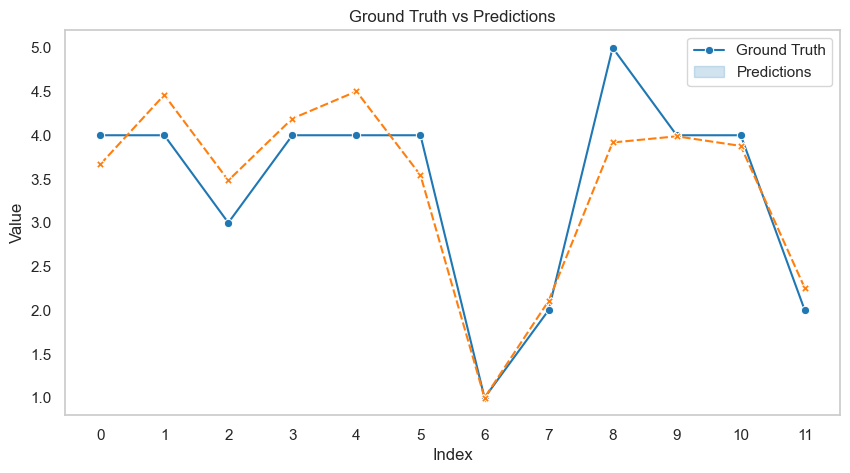

In [7]:
plot_ground_truth_vs_predictions(y, preds, True, model_dir)

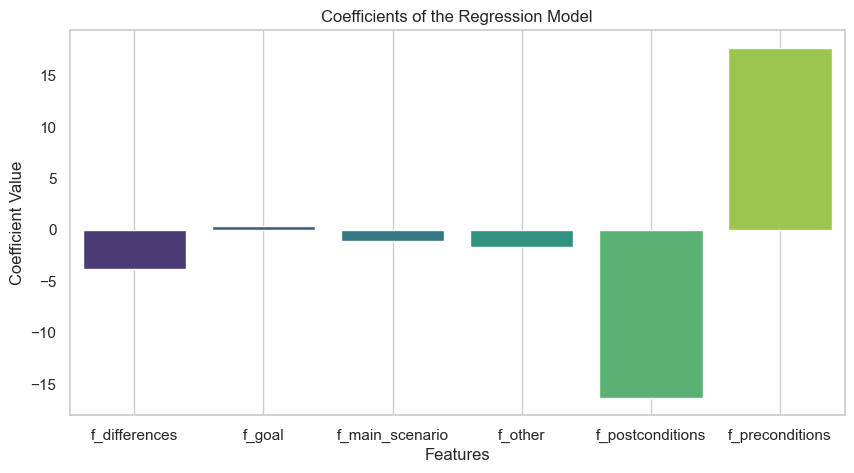

In [8]:
plot_coefficients(model.coef_, X.columns, True, model_dir)

# Saving model

In [9]:
obj_to_pickle(model, model_dir / create_model_name(model))